<a href="https://colab.research.google.com/github/akirakudo901/qlearning_demonstration_mint/blob/master/qlearning_demonstration_MINT_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reinforcement learning demonstration**
This notebook demonstrates the **basic training loop** for **reinforcement learning** through **q-learning** and the **epsilon-greedy algorithm**.
Tried to make it as brief as possible, so please ask anything you're unsure about!

____________________________________________

## **WHAT IS REINFORCEMENT LEARNING?**

### The four features of reinforcement learning (RL)

RL comes down to **four** features:
* **Environment** - the world that we want to learn from. A single situation in an environment is a **"state"**.
* **Agent** - the entity that learns through observing the environment and taking actions.
* **Observation** - what the agent perceives about the world.
* **Action** - what the agent does.
______________________________________________

### Agent-environment interaction (step)

*A nice [16 second illustration](https://www.youtube.com/watch?v=-uXVu0l8guo&t=12s) of the flow on YouTube!*

We represent a single **"step"** of agent-environment interaction as follows:
1. the agent **observes** the environment
2. it **chooses action** based on observation
3. the action **modifies** the environment (& environment might also change naturally)

In the next step, the agent observes the new environment state, takes action,
which modifies the environment, and so on.
A step is a single time step in the agent's view.

______________________________________________

### Reward function and policy learning

The agent **learns from interacting** with the world:
* a **"reward function"** inherent in the environment and hidden from the agent, evaluates **each state & action's rewarding-ness** to the agent in **numerical values**
* the agent learns through **associating actions** taken in certain states with **resultant rewards**.
Different algorithms (Q-learning, deep neural networks, etc.) are used for the agent's learning
* the agent **starts off knowing nothing about the world**, and explores the world **taking random actions**
* its goal is to **learn a guiding rule** for **action maximizing reward** at each state (called **"policy"**)

Our goal is to let the agent **learn a highly performant policy**.
Usual RL training involves the agent interacting a lot with the environment.
______________________________________________

### What changes from problem to problem for RL

We change:
* **ENVIRONMENT** : the world we learn from depends on the problem + (also includes observations and actions)
  
  <- probably the **software & signal processing team**'s field!

* **REWARD FUNCTION** : what quantifies the goal of the agent
  
  <- probably the **whole team**'s field! (maybe more on the deep learning team?)

* **AGENT'S LEARNING ALGORITHM** : the algorithm by which the agent learns
  
  <- probably the **deep learning team**'s field!

The general flow of problem solving stays the same for most RL problems!

_____________________________________

#### **SPECIFICS:**
Some lines of code are noted with SPECIFICS, relating to the nature of Q-learning rather than RL in general.
If interested further, read [this online article](https://blog.floydhub.com/an-introduction-to-q-learning-reinforcement-learning/)!

In [1]:
# First install dependencies as required:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.9 MB/s eta 0:00:00


In [2]:
import gymnasium
import numpy as np
import random, time, math, tqdm

In [3]:
# Make a folder which will store the qtables for us:
!mkdir qtable

## **Setting the learning algorithm (Q-table) up**

In [4]:
# SPECIFICS: Can be skipped if not curious about Q-learning!
# Q-table setup and roughly how it works.

QTABLE_FOLDER_PATH = "./qtable/"
DEFAULT_QTABLE_PATH = "./qtable/default.npy/"

class Qtable:
    NP_ARRAY_WIN_SIZE = np.array([0.25, 0.25, 0.01, 0.1])

    # Creating a new Q table
    def __init__(self):
        # determines how small we chop the observation space
        discretized_observation = [30, 30, 50, 60]
        env = gymnasium.make("CartPole-v1")
        # setting up initial values for the table
        self.Q = np.random.uniform(
            low=0, high=1,
            size=(discretized_observation + [env.action_space.n])
            )
        # print(Q.shape)

    # "state" is discrete
    def get_optimal_action(self, state):
        return np.argmax(self.Q[state])

    # "state" is discrete
    def update_state_action_reward(self, state, action, reward):
        self.Q[state + (action, )] = reward

    # "state" is discrete
    def get_reward(self, state, action):
        return self.Q[state + (action, )]

    # "state" is discrete
    def get_best_reward(self, state):
        return np.max(self.Q[state])

    # "state" is discrete
    def update_given_state_action_next_state_pairs_in_time_order(
        self, s_a_n_s, rEpisode
        ):
        s_a_n_s.reverse()
        for pairs in s_a_n_s:
            s, a, n_s = pairs[0], pairs[1], pairs[2]
            r = self.get_reward(s, a) + ALPHA * (rEpisode + GAMMA * (self.get_best_reward(n_s) - self.get_reward(s, a)))
            self.update_state_action_reward(s, a, r)

    # saves the table into a .npy file
    def save_table(self, name=None):
        time_of_creation = time.localtime(time.time())[0:5]
        acc = str(time_of_creation[0])
        [acc := acc + "_" + str(x) for x in time_of_creation[1:5]]
        name_original = "Cartpole_Q_table_" + acc

        if name is None:
            name = name_original

        name = QTABLE_FOLDER_PATH + "/" + name
        np.save(name, self.Q)

    # loads the .npy file table into a numpy array
    def load_table(self, path=None):
        if path is None:
            path = DEFAULT_QTABLE_PATH

        self.Q = np.load(path)

    # Maps each continuous state vector obtained from env to a discrete state
    # stored in Q table
    # Divides the state array by the window sizes specified by ARRAY_WIN_SIZE,
    # then adds the np.array to turn them to values above 0 (and hopefully
    # within range of the Q table)
    @staticmethod
    def get_discrete_state(state):
        discrete_state = state/Qtable.NP_ARRAY_WIN_SIZE + np.array([15,10,1,10])
        return tuple(discrete_state.astype(int))

## **Preparing the training code**

In [5]:
EPISODES = 60000
ALPHA = 0.1 # learning rate
GAMMA = 0.95 # discount rate
INITIAL_EPSILON = 1 # probability for exploration
EPSILON_DECAY_VALUE = 0.99995

RENDER_TRAINING = False
SAVE_TRAINING_RESULT = True
TRAIN_AGENT = True

#+++++++++++++++++++++++++++++++++++++++
#Training

def train():
    # setup environment
    r_m = "human" if RENDER_TRAINING else None
    env = gymnasium.make("CartPole-v1", render_mode=r_m) # setting environment up

    # setup algorithm that learns what action to take.
    # In our case, we use specifically the qtable for qlearning.
    Q = Qtable()

    prior_reward = 0
    epsilon = INITIAL_EPSILON

    # Single episode loop:
    for episode in tqdm.tqdm(range(EPISODES)):#tqdm makes training progress bar
        # training:
        # 0) reset the environment (env), and setup appropriate values:
        # - state of env
        # - rewards over episode (0)
        # - done or not? which is False
        # - array storing pairs of state, action and next state required to
        #   update the q-table
        # - epsilon for epsilon-greedy, which decreases by a complex value each
        #   episode (check detail in code)

        s, _ = env.reset()
        s_disc = Qtable.get_discrete_state(s)
        rEpisode = 0
        d = False

        # SPECIFICS: Q-TABLE AND STORING STATE ACTION NEXT STATE PAIRS
        # Pairs of state, action and next state in episode used at the episode's
        # end to update values of each actions given each state (as related to
        # entire reward in episode)
        state_action_nextstate_pairs = []

        # Training loop:
        while not d:

            # SPECIFICS: WHAT IS EPSILON-GREEDY?
            # SPECIFICS: HOW IS THE OPTIMAL SOLUTION DETERMINED IN Q LEARNING?
            # -) choose an action: if epsilon is greater than random value,
            #    choose optimal solution so far
            #    otherwise choose an action at random in the action space

            optimal_action = Q.get_optimal_action(s_disc)
            random_action = random.sample([0, 1], 1)[0]

            threshold = random.random()
            a = optimal_action if (threshold > epsilon) else random_action

            # -) update the environment accordingly given the action, taking:
            # new state, new reward, done?, info
            n_s, r, terminated, truncated, _ = env.step(a)

            if terminated or truncated:
                d = True

            n_s_disc = Qtable.get_discrete_state(n_s)
            state_action_nextstate_pairs.append([s_disc, a, n_s_disc])

            # -) update info to adjust at the end of the step
            s_disc = n_s_disc
            rEpisode += r

        # Then adjust epsilon accordingly once a single episode loop is over.
        if epsilon > 0.05: #epsilon modification
            if rEpisode > prior_reward and episode > 10000:
                epsilon = math.pow(EPSILON_DECAY_VALUE, episode - 10000)

        # Update qtable appropriately
        # SPECIFICS: HOW IS THE QTABLE UPDATED?
        Q.update_given_state_action_next_state_pairs_in_time_order(
            state_action_nextstate_pairs, rEpisode
            )

    # End of training
    env.close() # close the training env
    if SAVE_TRAINING_RESULT:
        Q.save_table()

    return Q

## **Preparing the evaluation code**

In [6]:
#+++++++++++++++++++++++++++++++++++++++
#Evaluating

def evaluate(qtable=None, path=None):
    if qtable is None:
        Q = Qtable()
        Q.load_table(path)
    else:
        Q = qtable

    # Evaluation loop:
    env_eval = gymnasium.make("CartPole-v1", render_mode="human")
    s, _ = env_eval.reset() #reset the environment

    s_disc = Qtable.get_discrete_state(s)
    terminated = truncated = False

    while not (terminated or truncated):

        # get optimal action by agent
        a = Q.get_optimal_action(s_disc)

        # update env accordingly
        s, _, terminated, truncated, _ = env_eval.step(a)
        s_disc = Qtable.get_discrete_state(s)

    env_eval.close()

In [7]:
# Great code from here[https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553]!
from matplotlib import animation
import matplotlib.pyplot as plt

"""
Ensure you have imagemagick installed with
sudo apt-get install imagemagick

Open file in CLI with:
xgd-open <filelname>
"""
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

def evaluate_while_returning_gif(qtable=None, path=None):
    if qtable is None:
        Q = Qtable()
        Q.load_table(path)
    else:
        Q = qtable

    # stores frames to be stored as gif
    frames = []

    # Evaluation loop:
    env_eval = gymnasium.make("CartPole-v1", render_mode="rgb_array")
    s, _ = env_eval.reset() #reset the environment

    s_disc = Qtable.get_discrete_state(s)
    terminated = truncated = False

    while not (terminated or truncated):

        # get optimal action by agent
        a = Q.get_optimal_action(s_disc)

        # update env accordingly
        s, _, terminated, truncated, _ = env_eval.step(a)

        #Render to frames buffer
        frames.append(env_eval.render())

        s_disc = Qtable.get_discrete_state(s)

    env_eval.close()
    save_frames_as_gif(frames)

## **Executing the codes**

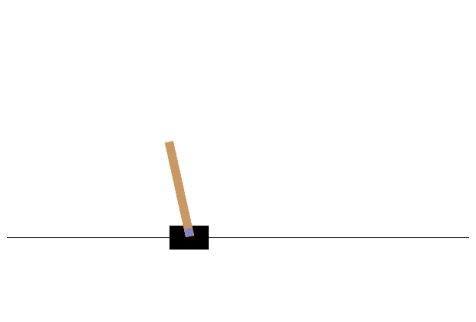

In [10]:
#First train, details in train function.
# +++++++++++++++++++++++++++++++++
# + TAKES ABOUT 6 MIN TO TRAIN!!! +
# +++++++++++++++++++++++++++++++++

if TRAIN_AGENT:
    qtable = train()

# Evaluation. See it in action, and some metrics! (TODO ADD METRICS! TO COME).
# DOES UNFORTUNATELY NOT WORK WITH GOOGLE COLAB; SAVE RESULTS AS GIF TO SEE!
# evaluate(qtable=qtable)

# If we want to evaluate a specific saved q-table, use the code below
# DOES UNFORTUNATELY NOT WORK WITH GOOGLE COLAB; SAVE RESULTS AS GIF TO SEE!
# evaluate(path="qtable\Cartpole_best_performing.npy")

# If we want to save the result as gif, run below
# evaluate_while_returning_gif(qtable=qtable)
# evaluate_while_returning_gif(path="/content/qtable/FILL_WITH_ACTUAL_QTABLE")